# Brazilian Wildfires Analysis between years 1998 and 2017
By José Brunfman - 
EY - Solutions Architect

## Introduction

I have selected a dataset from Kaggle that contains the amount of wildfire alarms registered in each brazilian state between 1998 and 2017. The dataset has some limitations, because it only has monthly records, and it does not specify any other data, like fire intensity, area affected, etc. Nevertheless, we can still use it to extract some valuable information. At the end of this notebook I also list some enrichements  that can be made, in order to improve results and correlate new variables to the analysis and predictions.

With a total area of more than 8.5 million of km2, it is the fifth larger country of the world and the larger of Latinamerica.The Amazon rainforest plays an important role in regulating the world's oxygen and carbon cycles. It produces roughly six percent of the world's oxygen and has long been thought to act as a carbon sink, meaning it readily absorbs large amounts of carbon dioxide from the atmosphere.

As we know, the Amazon rainforest produces roughly six percent of the world's oxygen and has long been thought to act as a carbon sink, meaning it readily absorbs large amounts of carbon dioxide from the atmosphere.

In terms of bio diversity, Brazil is at the top among the 18 megadiverse countries. It hosts between 15 and 20 per cent of the world's biological diversity, with more than 120,000 species of invertebrates, about 9,000 vertebrates and more than 4,000 plant species.

For these reasons, wildfires affecting Brazil are a great threat to the whole World, and analyzing them is extremely important.

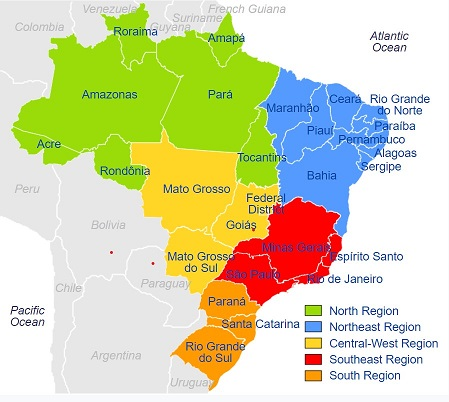

Following, I divide this notebook in the following sections:
- Import all the libraries we are going to use
- Load Brazil wildfires statistics into data dataframe
- Transformations
- Data Exploration
- Machine Learning for Descriptive and Predictive Analytics
- Final Summary

## Import all the libraries we are going to use

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import pacf
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
import itertools
from pmdarima import auto_arima
#from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates

## Load Brazil wildfires statistics into data dataframe

In [2]:
data = pd.read_csv('brazil_fires2.csv',encoding = "ISO-8859-1",delimiter=',')

In [3]:
data.drop(columns=['date'],inplace=True)

## Transformations

#### Will create/modify the following datasets:
- data: remove redundant columns
- states: converts states values into separate columns, that will be used later for correlations and predictions
- monthly_summary: agregation of each month's fire alarm averages
- monthly: resamples the whole time series by month
- yearly: resamples the whole time series by year

In [4]:
dates=pd.to_datetime([f'{y}-{m}' for y, m in zip(data.year, data.month)])
data['date']=dates
data = data.reset_index()
data['year_month'] = data['date'].apply(lambda x: x.strftime('%Y-%m'))
data.set_index('year_month', inplace=True)
data.number=data.number.astype(int)
data.index = pd.to_datetime(data.index)

In [5]:
data.drop(columns=['index','date'],inplace=True)

In [6]:
data.sort_index(inplace=True)

In [7]:
states=data.groupby([data.index, data.state])['number'].aggregate('first').unstack()

In [8]:
states_summary=data.groupby(data.state).sum()
states_summary.drop(columns=['year'],inplace=True)
states_summary.number=states_summary.number.astype(int)

In [9]:
states_summary.sort_values('number',ascending=True,inplace=True)

In [10]:
monthly_summary=data.groupby(data.month).mean()
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
monthly_summary.index = pd.Categorical(monthly_summary.index, categories=months, ordered=True)
monthly_summary.sort_index(inplace=True)

In [11]:
#daily=data.resample('D').sum()
#weekly=data.resample('W').sum()
monthly = data.resample('M').sum()
yearly=data.resample('Y').sum()

## Data Exploration

###### We start showing the total number of fires registered in each state during the period. As we can see, Mato Grosso accounts for 14% of the total.

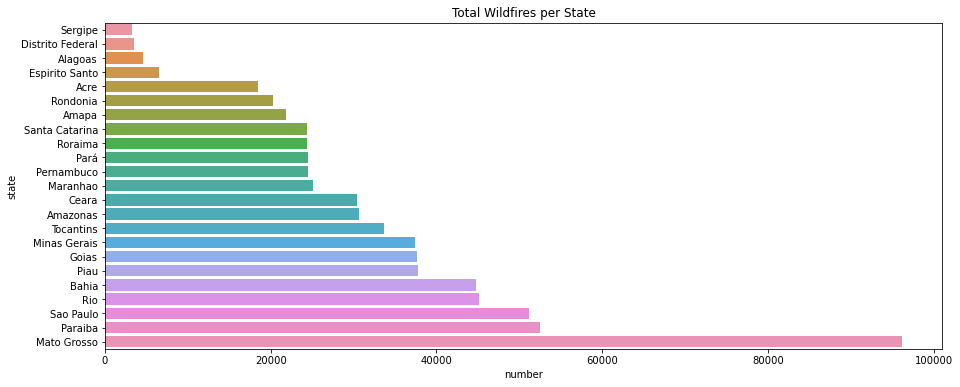

In [12]:
plt.figure(figsize = (15,6))
plt.title("Total Wildfires per State")
sns.barplot(states_summary.number,states_summary.index)

###### As said, Mato Grosso accounts 14% of wildfire counts, but it has 16% of the total area. On the contrary, the following eight states called my eye; because their contribution to the number of widfire surepasses their relative area. For example: Paraiba concentrates 8% of the total wildfires, BUT is only 1% of the total area.

In [13]:
risky_states = pd.read_csv('Brazil wildfire vs. area.csv',delimiter=';')

In [14]:
risky_states

State Fires % from total Area % from total
0     Paraiba                 8%                1%
1    SaoPaulo                 7%                3%
2         Rio                 6%                1%
3       Piaui                 5%                3%
4       Goias                 5%                4%
5   Tocantins                 5%                3%
6       Ceara                 4%                2%
7  Pernambuco                 4%                1%

###### Now, let's see the total number of fires each month. At the naked eye, we can infer a strong year seasonality. Against my initial assumption, the higher number of fires are reported during winter. This can be explained by the lower number of rains during this season.

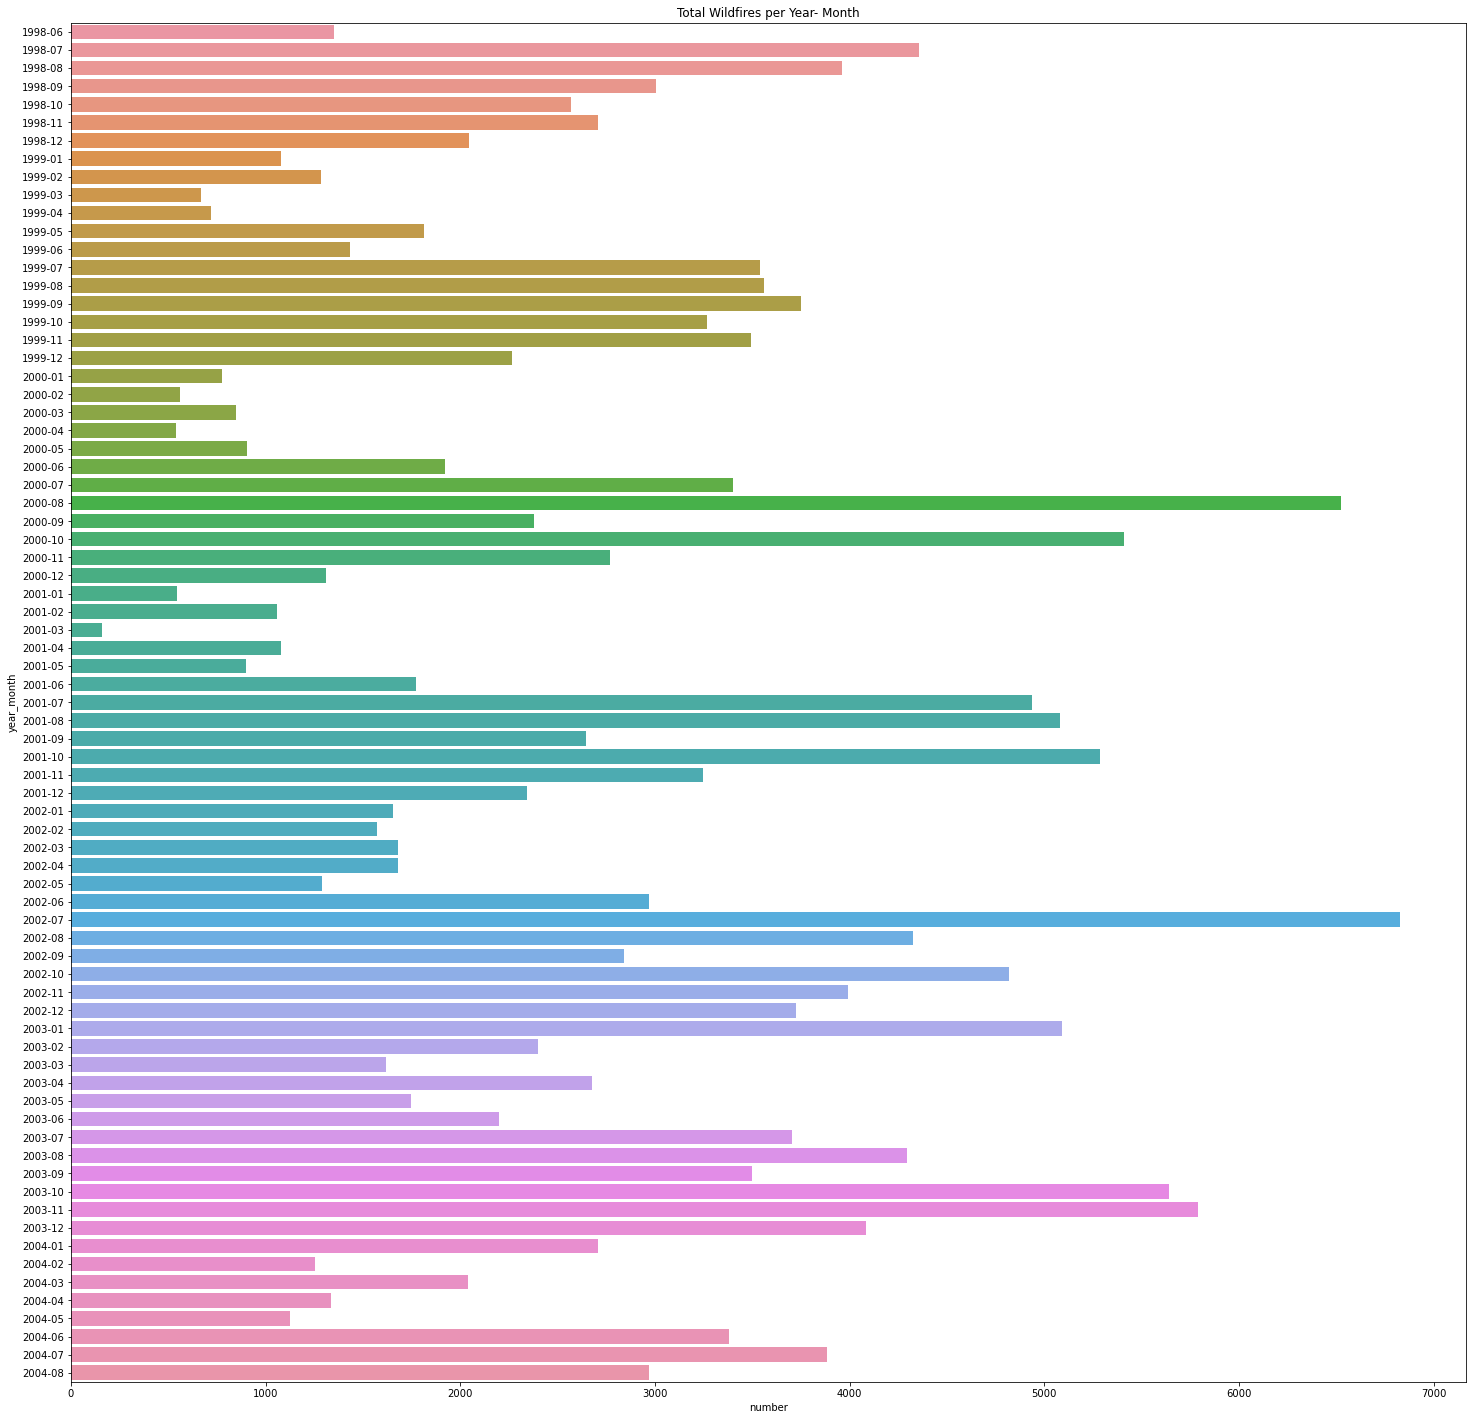

In [15]:
plt.figure(figsize = (25,25))
#plt.xticks(rotation=90)
plt.title("Total Wildfires per Year- Month")
sns.barplot(y=monthly.index[5:80].strftime('%Y-%m'), x=monthly.number[5:80])

###### Below, is a summary of the total number of rains registered each year. Trend is slightly percibed, but later we are going to use seasonal decompose function that will show the trend  

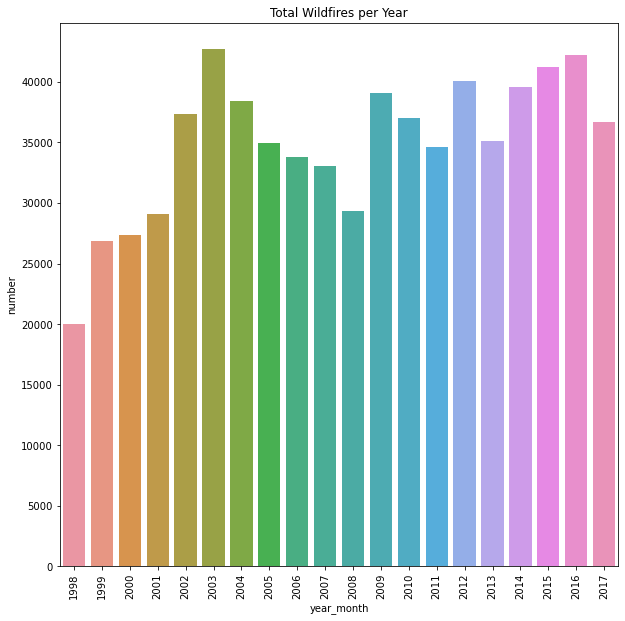

In [16]:
plt.figure(figsize = (10,10))
plt.xticks(rotation=90)
plt.title("Total Wildfires per Year")
sns.barplot(yearly.index.strftime('%Y'), yearly.number)

###### Below, Seasonal Decompsose shows the presence of a sostained growing trend and seasonality

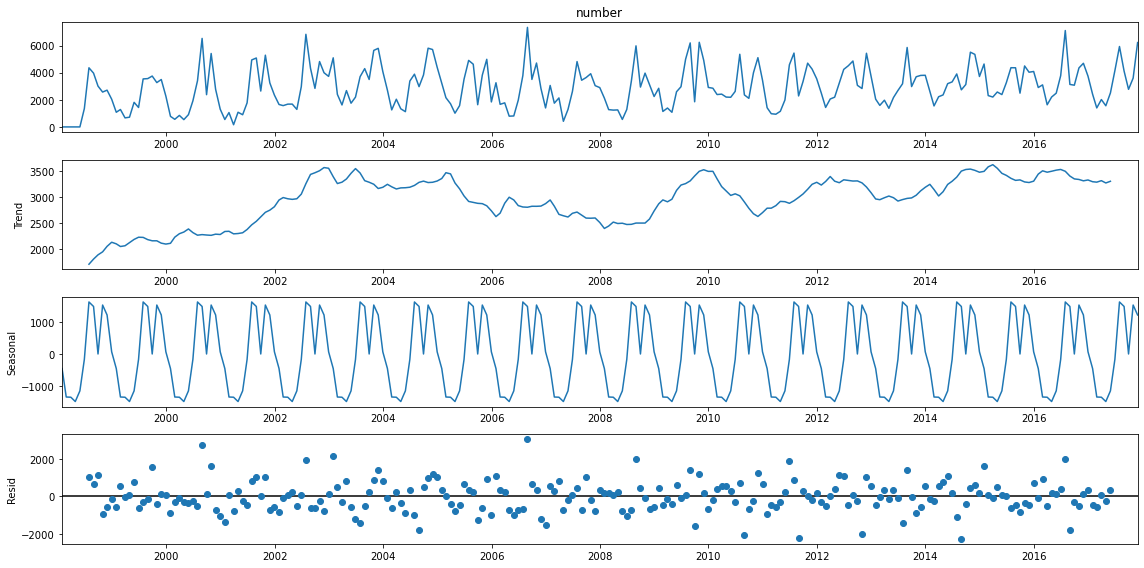

In [17]:
result = seasonal_decompose(monthly['number'],model='additive')
plt.rc("figure", figsize=(16,8))
result.plot();

###### This chart confirms the seasonallity of the data, with July an August concentraiting the highest number of fires 

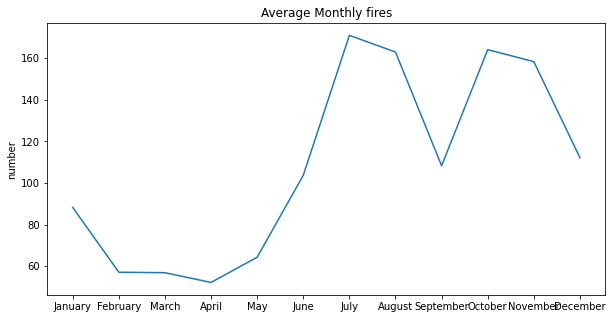

In [18]:
plt.figure(figsize = (10,5))
plt.title("Average Monthly fires")
sns.lineplot(monthly_summary.index,monthly_summary.number);


###### Do all states follow the same seasonallity? We think so. Below chart show the behaivour of the 4 top states that seem to have a similar pattern

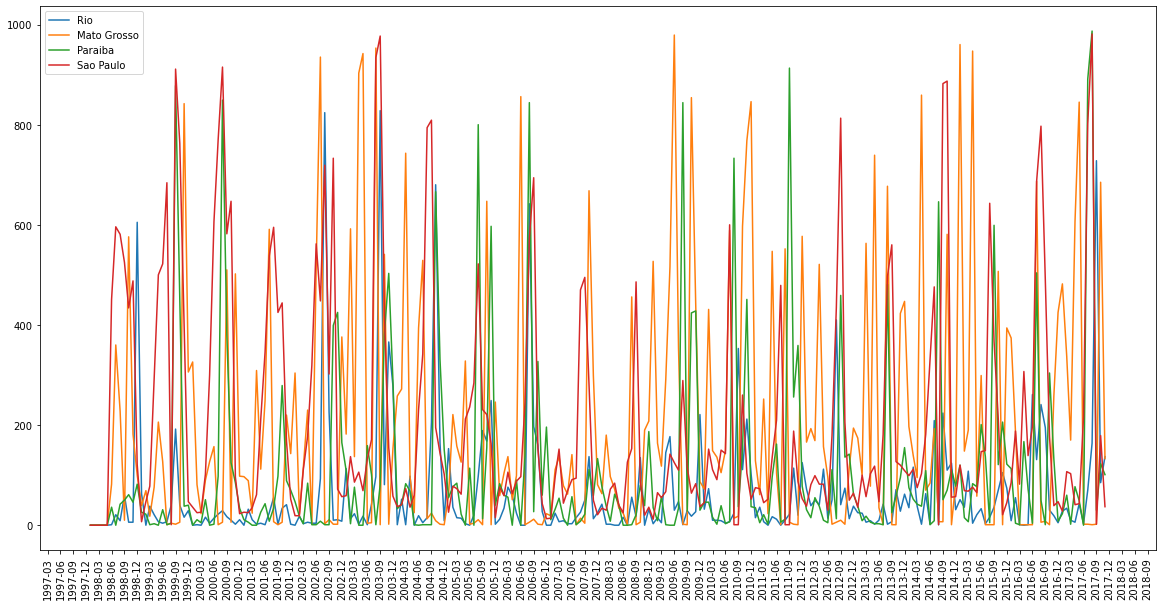

In [19]:
#plt.rc("figure", figsize=(16,8))

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(rotation=90)
myFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
sns.lineplot(data=[states.Rio,states['Mato Grosso'],states['Paraiba'],states['Sao Paulo']],dashes=False)

###### Finally, before starting our ML experiments, let's heatmap the correlation between states. In general, we DO NOT see a strong correlation with the exception of Alagoas and Sergipe (72%). And that may be explained because they are small and neightbours; so it would be highly probable that when a fire starts in one of them it easily spreads to the other. Nevertheless, be aware that in timeseries correlation could be hidden. For example, it could happened that fires use to start in state A and spreads to state B  by the effect of wind (lag correlation). Let's see if it possible to repesent that correlation later during the ML section.

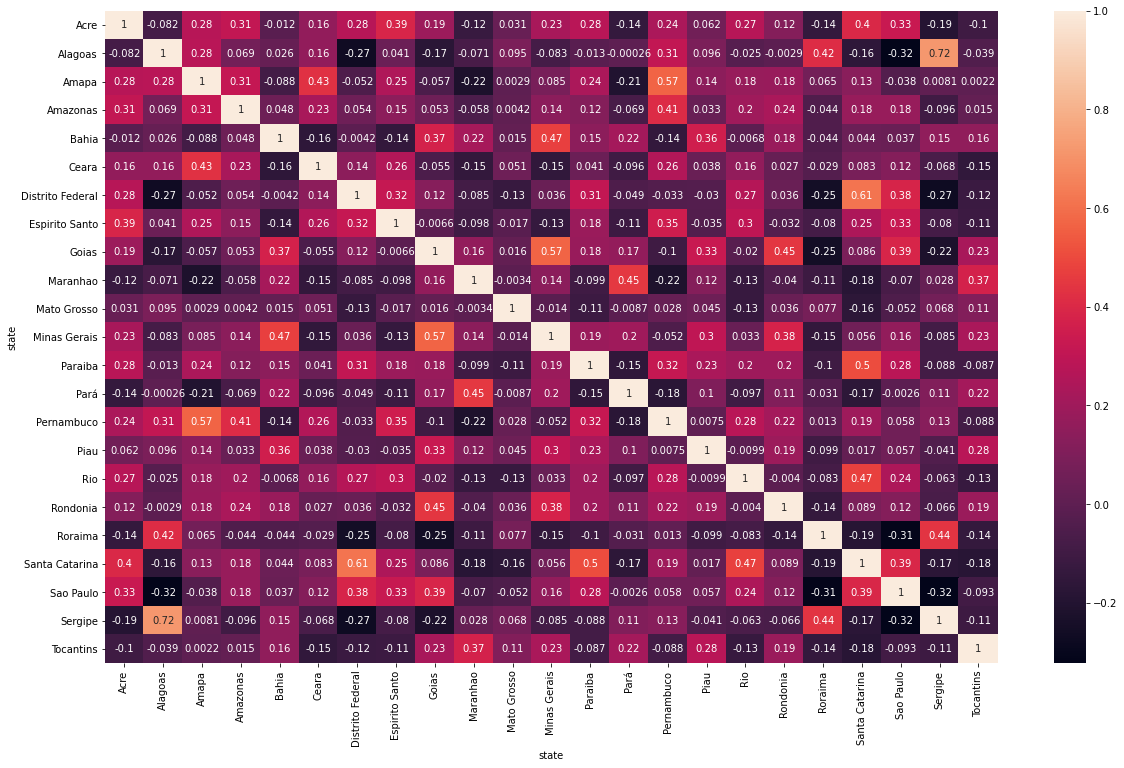

In [20]:
corr=states.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr,annot =True)

## Machine Learning for Descriptive and Predictive Analytics

###### Let's start checking the autocorrelation of the monthly dataset below

In [21]:
len(monthly)

239

In [22]:
nlags= 239
autoc= acf(monthly.number, nlags= nlags, fft=False)
autoc.shape

(239,)

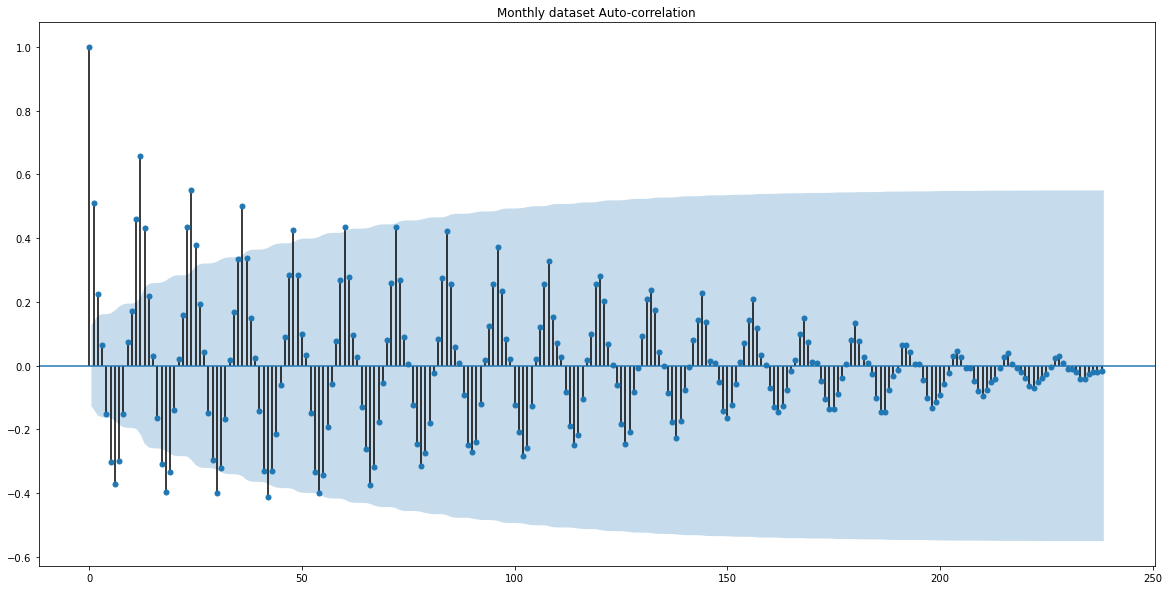

In [23]:
fig, axes = plt.subplots(figsize=(20,10))
plot_acf(monthly.number, lags = nlags-1,ax=axes,use_vlines=True,title="Monthly dataset Auto-correlation");

###### We confirm here that the auto-correlation follows a yearly pattern as already shown in the previous section.

### Random Forest - Wildfires Prediction in the Whole Country

To start, will run an experiment using the monthly dataset, that resampled the total number of fires per month in the whole country, I will train the model with a subset of the data and try to predict the following months. Then will use Root Mean Square Error to score the results 

I first create the signal dataset extracted from the monthly dataframe

In [24]:

signal = monthly.number
type(signal)

pandas.core.series.Series

In [25]:
#look_back = 24 #Previous values to make a prediction
look_back = 40 #Previous values to make a prediction

Inicialization of X and y variables

In [26]:
N = signal.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(198, 40) (198,)


Save in X and y the series values

In [27]:

for i in range(X.shape[0]):
    X[i,:] = signal.iloc[i:i+look_back]
    y[i] = signal.iloc[i+look_back]

In [28]:
look_back

40

Separate train and test datasets

In [29]:
N_train = 210 - look_back # instances used for training. 
N_test = 28 #instances used for test

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(170, 40) (170,)
(28, 40) (28,)


Create a new instance of Random Forest Regressor

In [30]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=100, n_jobs = 4).fit(X_train,y_train)

Generate train, test and complete series predictions

In [31]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

Chart results

<Figure size 1152x576 with 0 Axes>

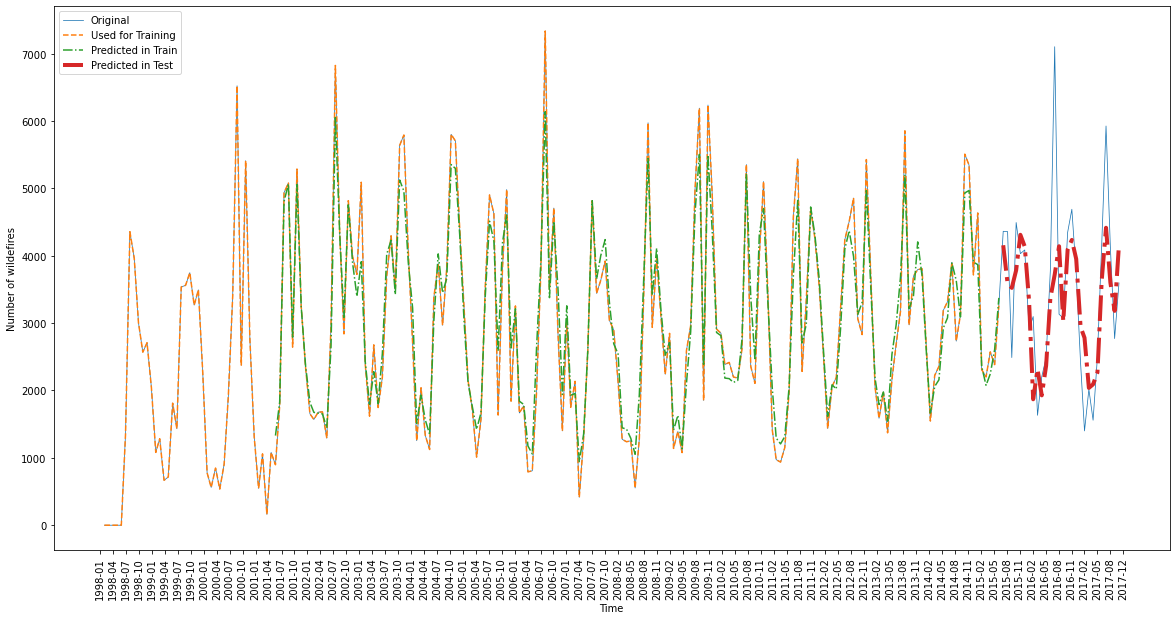

In [32]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(signal.index[:length_total], signal[:length_total],lw = 0.75, label = 'Original')
plt.plot(signal.index[:N_train + look_back], signal[:N_train + look_back],'--', label = 'Used for Training')
plt.plot(signal.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicted in Train')
plt.plot(signal.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicted in Test')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of wildefires')
plt.xticks(rotation=90)
myFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(pd.date_range(start='1998-01', end='2017-12',periods=80));

Let's see the RMSE

In [33]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error in Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error in Test:',np.sqrt(MSE))

MSE = mean_squared_error(y_pred, y)
print('Error in whole series:',np.sqrt(MSE))

Error in Train: 374.1497743755756
Error in Test: 912.5975164273052
Error in whole series: 487.81789675859557


###### Conclusion: As we can see in the chart above, the model had a good overall understanding of the dataset and was able to predict fluctuations very well. It mainly failed due to outliers, like those occuring in 2016-11. If I had removed outliers during the preparation steps, certainly would have improved these results 

### Random Forest Predicion for a single State Prediction

Now, let's assume we want to predict a single state wildfires using random forests. The procedure will be similar than the previuos one; the main difference is that I will use the states dataset, that was created at the data preparation section.

I will take one state (Mato Grosso),and train our model to predict the number of fires in it, based on the data from other states. That will indicate there is a temporal correlation between them. In other words, Mato Grosso will be our target and the rest of states features used for prediction. 

In [34]:
signal = states['Alagoas']

In [35]:
#look_back = 24 #Previous values to make a prediction
look_back = 40 #Previous values to make a prediction

In [36]:
N = signal.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(198, 40) (198,)


In [37]:
for i in range(X.shape[0]):
    X[i,:] = signal.iloc[i:i+look_back]
    y[i] = signal.iloc[i+look_back]

In [38]:
N_train = 210 - look_back # instances used for training. 
N_test = 28 #instances used for test

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(170, 40) (170,)
(28, 40) (28,)


In [39]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=100, n_jobs = 4).fit(X_train,y_train)

In [41]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

<Figure size 1152x576 with 0 Axes>

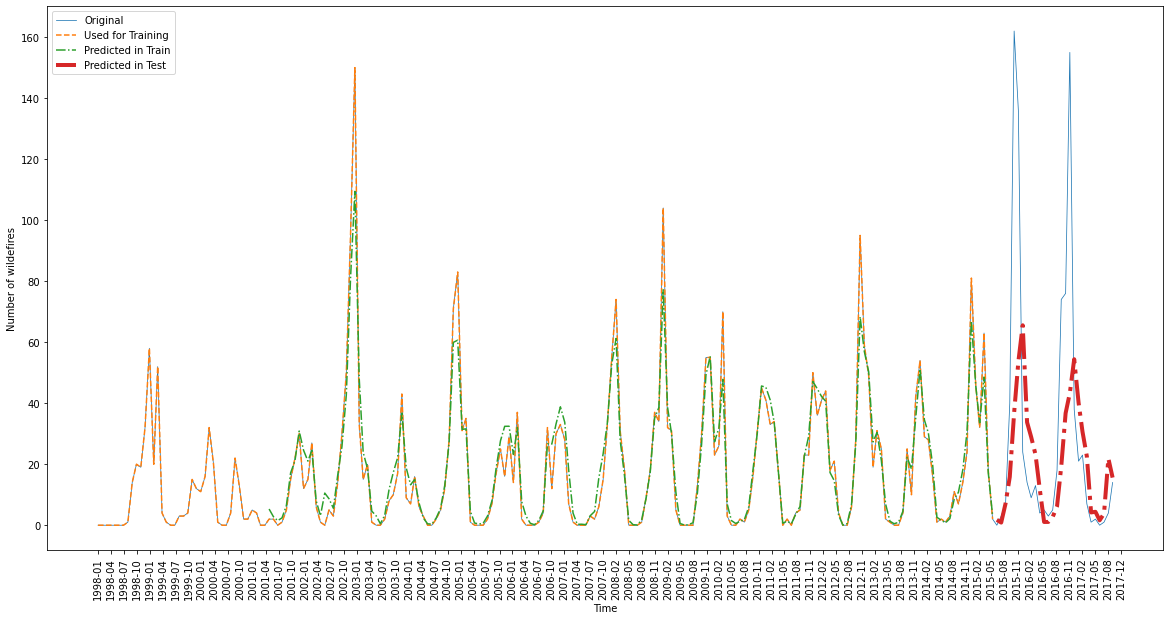

In [42]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(signal.index[:length_total], signal[:length_total],lw = 0.75, label = 'Original')
plt.plot(signal.index[:N_train + look_back], signal[:N_train + look_back],'--', label = 'Used for Training')
plt.plot(signal.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicted in Train')
plt.plot(signal.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicted in Test')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of wildefires')
plt.xticks(rotation=90)
myFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(pd.date_range(start='1998-01', end='2017-12',periods=80));

In [43]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error in Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error in Test:',np.sqrt(MSE))

MSE = mean_squared_error(y_pred, y)
print('Error in whole series:',np.sqrt(MSE))

Error in Train: 6.858258439540568
Error in Test: 39.71252244929443
Error in whole series: 16.22979471107495


###### Conclusions: again, the model was successful in identifying data fluctuations and failed to predict outliers. The RMSE for the test dataset was 40 points, and for the full dataset was 16.

### Prophet

In [44]:
monthly

year  number
year_month               
1998-01-31  53946       0
1998-02-28  53946       0
1998-03-31  53946       0
1998-04-30  53946       0
1998-05-31  53946       0
...           ...     ...
2017-07-31  54459    5926
2017-08-31  54459    4115
2017-09-30  54459    2771
2017-10-31  54459    3596
2017-11-30  54459    6217

[239 rows x 2 columns]

In [45]:
monthly.drop(columns=['year'],inplace=True)

In [46]:
monthly['DS']=monthly.index

In [47]:
monthly.index=range(monthly.shape[0])

In [48]:
monthly.columns

Index(['number', 'DS'], dtype='object')

In [49]:
monthly.columns=['y','ds']

In [50]:
m=Prophet()

In [51]:
m.fit(monthly)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
future = m.make_future_dataframe(periods=4,freq='M')
future

ds
0   1998-01-31
1   1998-02-28
2   1998-03-31
3   1998-04-30
4   1998-05-31
..         ...
238 2017-11-30
239 2017-12-31
240 2018-01-31
241 2018-02-28
242 2018-03-31

[243 rows x 1 columns]

In [53]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
238 2017-11-30  4758.752434  3667.757177  5816.978129
239 2017-12-31  3505.102752  2476.719876  4657.655997
240 2018-01-31  2922.309168  1786.404078  4048.921432
241 2018-02-28  2073.721769   993.833824  3136.486193
242 2018-03-31  2057.545167   976.123330  3163.386279

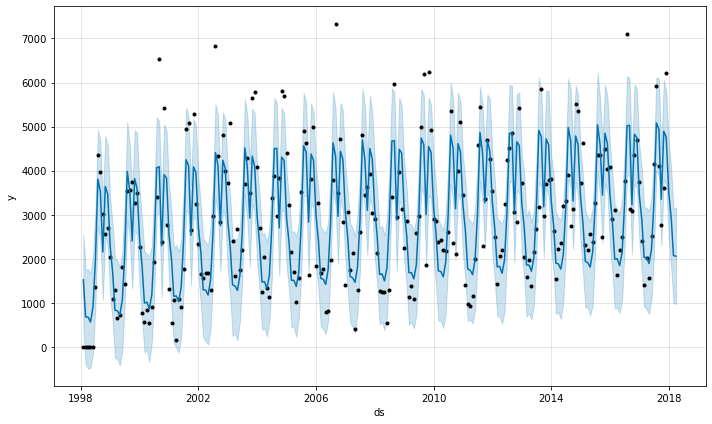

In [54]:
fig1 = m.plot(forecast)

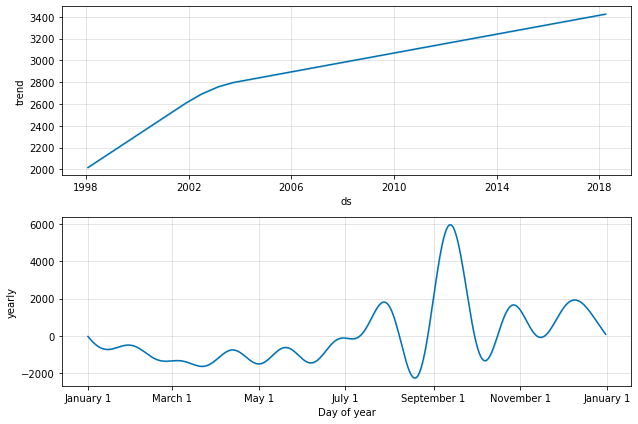

In [56]:
fig2 = m.plot_components(forecast)

In [57]:
plot_plotly(m, forecast)

In [91]:
 plot_components_plotly(m, forecast)

In [58]:
cutoffs = pd.date_range(start='2001-12-31', end='2017-12-31', freq='2MS')

Now, the cross_validation method is used to obtain error metrics with different time horizons

In [59]:
df_cv = cross_validation(m,horizon = '90 d',cutoffs=cutoffs)

In [133]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse         rmse          mae      mape     mdape  \
0 29 days  1.023463e+06  1011.663492   798.491183  0.256552  0.182826   
1 30 days  9.698119e+05   984.790281   730.057272  0.295697  0.224852   
2 58 days  5.798076e+05   761.450968   576.543250  0.289000  0.242325   
3 59 days  5.671019e+05   753.061717   590.384050  0.325205  0.296335   
4 60 days  9.349714e+05   966.939193   789.334782  0.354386  0.216014   
5 61 days  2.709711e+06  1646.119944  1333.365515  0.429473  0.205727   
6 89 days  1.662593e+06  1289.415853   916.180187  0.337895  0.200185   
7 90 days  8.600127e+05   927.368691   738.266162  0.211815  0.188292   

   coverage  
0  0.656250  
1  0.765625  
2  0.848011  
3  0.799716  
4  0.650794  
5  0.450216  
6  0.670455  
7  0.765152

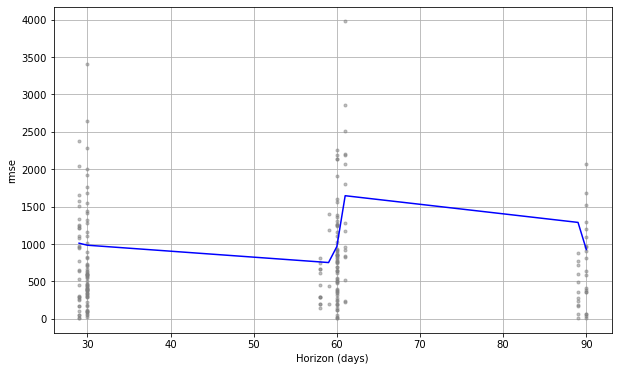

In [134]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

The next script will iterate a set of hyperparameters to identify the best combination of them,that generates the smaller RMSE value. 

In [137]:
cutoffs = pd.to_datetime(['1999-12-31', '2001-12-31', '2005-12-31'])
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params,daily_seasonality=True).fit(monthly)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001F9874637C0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001F98747EF10>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001F98243F790>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001F9821EF070>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  1855.851448
1                     0.001                     0.10   609.045180
2                     0.001                     1.00   552.825210
3                     0.001                    10.00   539.905166
4                     0.010                     0.01  1862.836190
5                     0.010                     0.10   616.073250
6                     0.010                     1.00   550.552903
7                     0.010                    10.00   539.079787
8                     0.100                     0.01  1861.846752
9                     0.100                     0.10   604.840803
10                    0.100                     1.00   663.131569
11                    0.100                    10.00   656.057076
12                    0.500                     0.01  1688.119819
13                    0.500                     0.10   765.598267
14        

###### Conclusions: 
Facebook Prophet did a better job than Random Forest messured as RMSE. While the latter obtained RSME of 912, the former, with a particular hyperparamiters combination, obtained 539. One caveat: Prophet does not have direct support of monthly horizon in cross validation, as reason is that not all months have same lenght. Used this workaround to overcome that limitation: https://github.com/facebook/prophet/issues/1672. 
Prophet offers a very rich toolset specialized in time series analysis.
###### Note: I see a difference between the yearly seasonallity detected by Prophet and the one I calculated before using seasonal_decompose from statsmodels. Further investigation can be needed to understand the cause.

### ARIMA

I start using auto_arima function to identify the optimal p, q and d values 

In [60]:
#Resetting monthly dataset to it's initial format, to get rid of the transformations required by Prophet library
monthly = data.resample('M').sum()

In [61]:
auto_arima(monthly['number'])

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [62]:
auto_arima(monthly['number'],error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  239
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2047.760
Date:                Sun, 17 Oct 2021   AIC                           4101.519
Time:                        21:37:54   BIC                           4111.936
Sample:                             0   HQIC                          4105.717
                                - 239                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5112      0.067      7.573      0.000       0.379       0.643
ma.L1         -0.9789      0.023    -41.854      0.000      -1.025      -0.933
sigma2      1.727e+06    1.4e+05     12.337      0.000    1.45e+06       2e+06
===================================================================================
Ljung-Box (Q):                      294.38   Jarque-Bera (JB):                22.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.72
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
train=monthly.iloc[:210]
test=monthly.iloc[210:]

In [64]:
model = ARIMA(train['number'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 number   No. Observations:                  210
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1798.449
Date:                Sun, 17 Oct 2021   AIC                           3602.899
Time:                        21:38:08   BIC                           3612.926
Sample:                    01-31-1998   HQIC                          3606.953
                         - 06-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5420      0.067      8.139      0.000       0.411       0.673
ma.L1         -0.9989      0.131     -7.596      0.000      -1.257      -0.741
sigma2      1.713e+06   2.18e+05      7.856      0.000    1.29e+06    2.14e+06
===================================================================================
Ljung-Box (Q):                      271.95   Jarque-Bera (JB):                19.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.71
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

Below chart compares predictions vs. reality

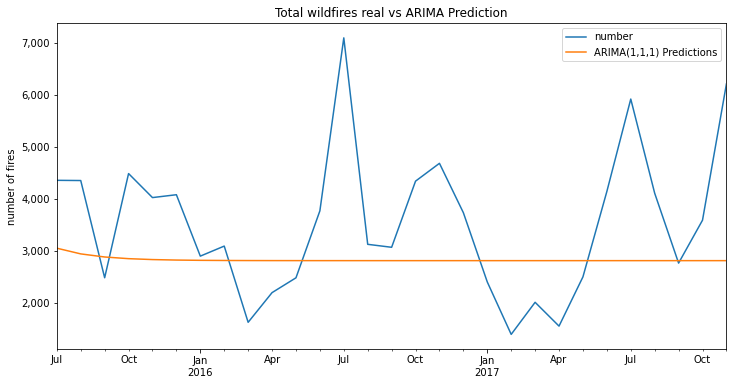

In [67]:
title = 'Total wildfires real vs ARIMA Prediction'
ylabel='number of fires'
xlabel='' # we don't really need a label here
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax = test['number'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

Print the RMSE

In [69]:
MSE = mean_squared_error(test.number, predictions)
print('Error in Train:',np.sqrt(MSE))

Error in Train: 1524.776357592079


In [70]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(monthly['number'],seasonal=True,m=12).summary()

C:\Users\jose.brunfman\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning:

Error fitting  ARIMA(3,1,0)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\jose.brunfman\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\jose.brunfman\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\jose.brunfman\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\jose.brunfman\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\jose.brunfman\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 654, in fit


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  239
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1976.210
Date:                            Sun, 17 Oct 2021   AIC                           3968.419
Time:                                    21:40:39   BIC                           3996.197
Sample:                                         0   HQIC                          3979.614
                                            - 239                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1305      0.072      1.816      0.069      -0.010       0.271
ar.L2         -0.0055      0.071     -0.077      0.939      -0.145       0.134
ar.L3         -0.0541      0.074     -0.727      0.467      -0.200       0.092
ar.L4         -0.1076      0.090     -1.200      0.230      -0.283       0.068
ma.L1         -0.9172      0.038    -24.226      0.000      -0.991      -0.843
ar.S.L12       0.9936      0.005    196.329      0.000       0.984       1.004
ma.S.L12      -0.8638      0.053    -16.152      0.000      -0.969      -0.759
sigma2      8.725e+05   2.27e-08   3.84e+13      0.000    8.72e+05    8.72e+05
===================================================================================
Ljung-Box (Q):                       38.85   Jarque-Bera (JB):                12.17
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.18
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+30. Standard errors may be unstable.
"""

In [71]:
model = SARIMAX(train['number'],order=(4,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

C:\Users\jose.brunfman\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             number   No. Observations:                  210
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1741.620
Date:                            Sun, 17 Oct 2021   AIC                           3499.240
Time:                                    21:41:11   BIC                           3525.978
Sample:                                01-31-1998   HQIC                          3510.050
                                     - 06-30-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2638      0.070      3.756      0.000       0.126       0.401
ar.L2          0.0496      0.070      0.705      0.481      -0.088       0.188
ar.L3          0.0324      0.048      0.673      0.501      -0.062       0.127
ar.L4         -0.0474      0.073     -0.647      0.518      -0.191       0.096
ma.L1         -0.9840      0.029    -33.362      0.000      -1.042      -0.926
ar.S.L12       0.9945      0.007    143.198      0.000       0.981       1.008
ma.S.L12      -0.8807      0.075    -11.670      0.000      -1.029      -0.733
sigma2      9.046e+05   3.83e-08   2.36e+13      0.000    9.05e+05    9.05e+05
===================================================================================
Ljung-Box (Q):                       55.66   Jarque-Bera (JB):                14.46
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.15
Prob(H) (two-sided):                  0.95   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+28. Standard errors may be unstable.
"""

In [72]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA (4,1,1)(1,0,1,12) Predictions')

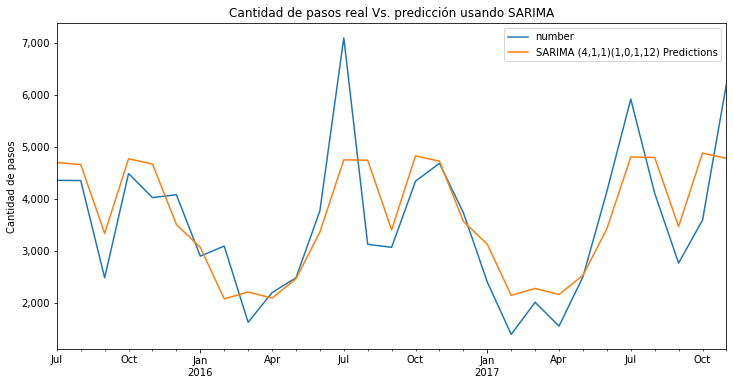

In [189]:
title = 'Number of wildfires vs. SARIMA predictions'
ylabel='Wildfires'
xlabel='' # we don't really need a label here
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax = test['number'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [73]:
MSE = mean_squared_error(test.number, predictions)
print('Error in Train:',np.sqrt(MSE))

Error in Train: 826.4846724184024


In [74]:
start=len(train)
start=0
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA (4,1,1)(1,0,1,12) Predictions FULL')

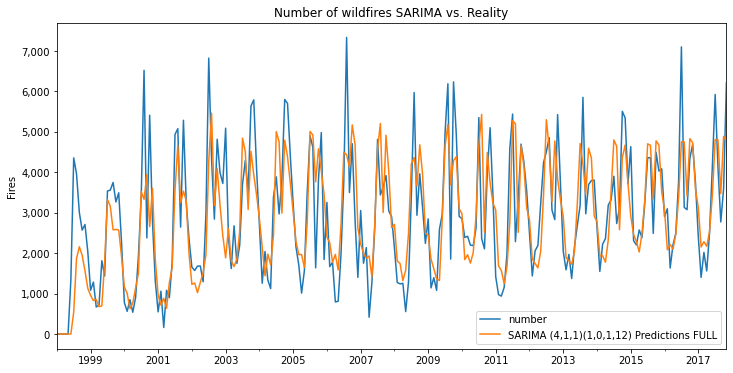

In [75]:
title = 'Number of wildfires SARIMA vs. Reality'
ylabel='Fires'
xlabel='' # we don't really need a label here
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax = monthly['number'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [76]:
MSE = mean_squared_error(monthly.number, predictions)
print('RMSE',np.sqrt(MSE))

RMSE 991.5771847213234


###### Conclusions: ARIMA had the worst performance (RMSE) but it improved significantly after we added the seasonallity component using SARIMA (from 1500 to 990). Nevertheless, still Facebook Profet achieved the best RMSE. 

## Final Summary

###### Trend

We observed a clear growing trend, in particular starting in 2005.

#### Seasonality

The series decomposition demonstarte the presence on yearly seasonality.

#### Models Benchmark

We run Random Fores, Profet and SARIMA. 
Facebook Profet seems to be the better fit, based on the the RMSE.

#### Correlation between states

With the exception of two small and geographycally close states, there is no strong correlation between states. 

I suspect there is a lag correlation (as explained in this article: https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9), but this dataset has only monthly data, and it could not be proven; to detect such temporal correlation would be needed a more granual dataset, that for example captures daily windfire alarms.

Another improvement related to correlation consists in adding exogenous variables, that we suspect have a strong impact in the time series, like whether conditions (temperature, rains, pressure). We can train a SARIMAX model and check if those features(called exogenous variables) have a strong relationship with the registered wildfires.